### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from tensorflow import keras

In [4]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 200
l = 6
num_filter = 35
compression = 1
dropout_rate = 0

<h3>Loading Data</h3>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [26]:
X_train.shape

(50000, 32, 32, 3)

In [27]:
X_test.shape

(10000, 32, 32, 3)

<h3>Standardizing Data</h3>

In [6]:
def prep_pixels(train, test):
# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
# normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
# return normalized images
    return train_norm, test_norm

In [7]:
X_train,X_test=prep_pixels(X_train,X_test)

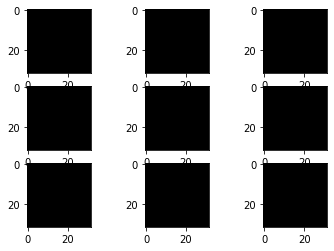

In [8]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

c=X_train[1]
c.shape
samples = expand_dims(c, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)

# prepare iterator
it = datagen.flow(samples, batch_size=1)

# generate samples and plot
for i in range(9):
    
    pyplot.subplot(330 + 1 + i)
    
    # generate batch of images
    batch = it.next()
    
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

<h2>Model without using Droupout Layers</h2>

In [9]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

<h3>Defining the model</h3>

In [10]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [11]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [12]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="./weights/weights-improve-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

callbacks_list = [checkpoint]

<h3>Image Augmentation</h3>

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(        
        rotation_range=30,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        zoom_range=0.10)

In [16]:
datagen.fit(X_train)

In [ ]:
# Fitting the model on the batches generated by datagen.flow()
history=model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test,y_test), 
                        epochs=epochs, workers=4,
                        callbacks=callbacks_list)

Epoch 1/200
390/390 [==============================] - 7186s 18s/step - loss: 1.4390 - accuracy: 0.4752 - val_loss: 1.5504 - val_accuracy: 0.4595
Epoch 2/200
390/390 [==============================] - 5675s 15s/step - loss: 1.0743 - accuracy: 0.6173 - val_loss: 0.9929 - val_accuracy: 0.6529
Epoch 3/200
390/390 [==============================] - 6809s 17s/step - loss: 0.8897 - accuracy: 0.6829 - val_loss: 1.2890 - val_accuracy: 0.5990
Epoch 4/200
390/390 [==============================] - 5723s 15s/step - loss: 0.7874 - accuracy: 0.7249 - val_loss: 1.0467 - val_accuracy: 0.6664
Epoch 5/200
390/390 [==============================] - 5301s 14s/step - loss: 0.7118 - accuracy: 0.7511 - val_loss: 0.8931 - val_accuracy: 0.7154
Epoch 6/200
390/390 [==============================] - 25164s 65s/step - loss: 0.6576 - accuracy: 0.7699 - val_loss: 0.8908 - val_accuracy: 0.7146
Epoch 7/200
390/390 [==============================] - 6347s 16s/step - loss: 0.6128 - accuracy: 0.7866 - val_loss: 0.8515 

In [0]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

In [0]:
model.load_weights('/content/drive/My Drive/CNN_on_CIFR/weights-improve-130.hdf5')

In [0]:
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',    
}

In [0]:
# import seaborn as sns; sns.set()
# import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_confusion_matrix

# print("="*50)
# print("Confusion Matrix") 
# print("="*50)
# fig = plt.subplots(1,1)
# sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), cmap="PuBu", annot=True, fmt="d")
# print()